In [54]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v1.set_random_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [1]:
import pandas as pd
import numpy as np
import re
import os, json
import matplotlib.pyplot as plt

## 讀取KG資料並轉呈DICT

In [2]:
def load_dict_from_file(dict,filepath):
    try:
        with open(filepath, 'r') as dict_file:
            for line in dict_file:
                (key, value) = line.strip().split('\t')
                value = value[1:-1].split(', ')
                #print部分為檢查用
                #print(key)
                #print(type(value))
                #print("-"*50)
                dict[key] = value
    except IOError as ioerr:
        print("檔案 %s 不存在" % (filepath))

In [3]:
entity = {}
relation = {}
load_dict_from_file (entity,'entityVector(20d).txt')
load_dict_from_file (relation,'relationVector(20d).txt')


## 將每日相對應的tuple依日期做成DataFrame

In [4]:
#讀取資料
t = open('Workday_tuple_ex.txt','r')

#建立之後要存每日tuple embedding 的df

col = []

col.append('Date')

for i in range(20):
    col.append('h'+str(i))
for i in range(20):
    col.append('r'+str(i))
for i in range(20):
    col.append('t'+str(i))
    
t_df = pd.DataFrame(columns=col)


for lines in t :
    dict = {}
    triple = lines[15:].replace('\n','').lower().split("-----")
    date = lines[:10].replace('/','-')
    
    dict['Date'] = date
    
    
    for i in range(20):
        dict['h'+str(i)] = float(entity[triple[0]][i][:11])
    for i in range(0,20):
        dict['r'+str(i)] = float(relation[triple[1]][i][:11])
    for i in range(0,20):
        dict['t'+str(i)] = float(entity[triple[2]][i][:11])
        
    #print(dict)
    
    new = pd.DataFrame.from_dict(dict,orient='index').T
    t_df = t_df.append(new,ignore_index = True)
    #print(date + 'is success')
    #print('-'*50)


t.close()


In [5]:
t_df.set_index('Date',inplace=True)

## 讀取股票基本資料

In [6]:
df = pd.read_csv('Financedata_2010_2017.csv').drop(index=[0])

## 整理之後要跟股票資料concate的DF(日期比照所有股票資料，無tuple的zero padding)

In [7]:
# zero padding
f_col = col.copy()

f_df =  pd.DataFrame(index = range(0,2014),columns = f_col)
for i in range(1,2014):
    if df['Date'][i] in t_df.index :
        for j in range(20):
            f_df['h'+str(j)][i] = t_df.loc[df['Date'][i]]['h'+str(j)]
            f_df['r'+str(j)][i] = t_df.loc[df['Date'][i]]['r'+str(j)]
            f_df['t'+str(j)][i] = t_df.loc[df['Date'][i]]['t'+str(j)]
    else:
        for j in range(20):
            f_df['h'+str(j)][i] = float(0)
            f_df['r'+str(j)][i] = float(0)
            f_df['t'+str(j)][i] = float(0)
            

        


In [8]:
d_df = f_df.drop(index = 0)
d_df = d_df.drop(columns = 'Date')

In [9]:
#將df轉成array
t_array = d_df.values

In [10]:
#f_df.to_csv("f_df_notech.csv")

## 後續在colab中，加上所需的技術指標，之後再轉成csv，在進行讀取

In [10]:
total_df = pd.read_csv('f_df_withtech.csv')

# Percentage change of adj price 取代 adj close price

In [13]:
tech_df = pd.DataFrame()

#基本資料
tech_df['Open'] = total_df['Open']
tech_df['High'] = total_df['High']
tech_df['Low'] = total_df['Low']
tech_df['Close'] = total_df['Close']
tech_df['Adj Close'] = total_df['Adj Close']
tech_df['Volume'] = total_df['Volume']
#技術指標
tech_df['Adx'] = total_df['Adx']
tech_df['Rsi'] = total_df['Rsi']
tech_df['Sar'] = total_df['Sar']
tech_df['Adj-1'] = total_df['Adj Close'].shift()

In [14]:
PCAP = []

for index, row in tech_df.iterrows():
    if (index == 0):
        PCAP.append(0)
    else:
        PCAP.append((row['Adj Close']-row['Adj-1'])/row['Adj-1'])

In [15]:
tech_df['PCAP'] = PCAP

In [16]:
tech_df = tech_df.drop(columns=['Adj-1','Adj Close'])

In [17]:
tech_df

,Open,High,Low,Close,Volume,Adx,Rsi,Sar,PCAP
0,7.622500,7.660714,7.585000,7.643214,493729600,0.000000,0.000000,0.000000,0.000000
1,7.664286,7.699643,7.616071,7.656429,601904800,0.000000,0.000000,7.585000,0.001729
2,7.656429,7.686786,7.526786,7.534643,552160000,0.000000,0.000000,7.699643,-0.015906
3,7.562500,7.571429,7.466071,7.520714,477131200,0.000000,0.000000,7.699643,-0.001849
4,7.510714,7.571429,7.466429,7.570714,447610800,0.000000,0.000000,7.690300,0.006648
...,...,...,...,...,...,...,...,...,...
2008,43.669998,43.855000,43.625000,43.752499,65397600,15.311032,60.293137,42.316421,0.000000
2009,42.700001,42.867500,42.419998,42.642502,132742000,15.205238,46.549483,44.299999,-0.025370
2010,42.525002,42.695000,42.427502,42.650002,85992800,15.107000,46.637989,44.262399,0.000176
2011,42.750000,42.962502,42.619999,42.770000,65920800,14.517060,48.118303,44.225551,0.002813


In [18]:
#將股票基本資料及技術指標進行標準化
from sklearn.preprocessing import MinMaxScaler
mmc = MinMaxScaler(feature_range=(-1,1)) # default (0, 1) for sigmoid function
mmc.fit(tech_df)
tech_array = mmc.transform(tech_df)
tech_array

array([[-0.95924134, -0.96457297, -0.95718584, ..., -1.        ,
        -1.        ,  0.16399997],
       [-0.95697694, -0.96248562, -0.95550269, ..., -1.        ,
        -0.65756207,  0.18028724],
       [-0.95740273, -0.963175  , -0.96033934, ..., -1.        ,
        -0.65238631,  0.01415333],
       ...,
       [ 0.93212703,  0.91394104,  0.93025536, ...,  0.03178927,
         0.99830248,  0.16565603],
       [ 0.94431971,  0.9282843 ,  0.94068306, ...,  0.06453879,
         0.99663891,  0.19050441],
       [ 0.93781697,  0.91139409,  0.92361938, ..., -0.04538015,
         0.99500862,  0.06212937]])

## 將 標準化完的array 跟 每日tuple的array 合在一起

## 將整理好的 array 再轉乘df 再進行合併

In [19]:
tea_df  = pd.DataFrame(tech_array)
ta_df  = pd.DataFrame(t_array)


In [20]:
taa_df = pd.concat([tea_df, ta_df], axis = 1)

In [21]:
final_array = taa_df.values

In [22]:
final_array.shape

(2013, 69)

In [24]:
final_array[5]

array([-0.9604606151299209, -0.967445418907735, -0.9647890678825901,
       -0.9653654748343927, -0.5462620342582922, -1.0, -1.0,
       -0.6532130373914652, 0.08089304561755996, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0], dtype=object)

# Y的製作

In [25]:
tmp = total_df
total_df['T+1'] = tmp['Adj Close'].shift(-1)

In [26]:
# Calculate the trend on T+1 and T+30


y = []

for index, row in total_df.iterrows():
    _tmp = []
    if (row['T+1']-row['Adj Close'] > 0):
        _tmp.append(1)
    else:
        _tmp.append(0)
        
    y.append(_tmp)
    
#djia.head(5)
y[0:10]

[[1], [0], [0], [1], [0], [0], [1], [0], [0], [1]]

In [27]:
y = np.asarray(y)
y.reshape(2013,1)

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [28]:
y.shape

(2013, 1)

# Windows size 設定5天

In [29]:
final_array.shape

(2013, 69)

In [30]:
# 5天做一個 window
def train_windows(df, df1, ref_day=5, predict_day=1):
    X_train = []
    Y_train = []
    for i in range(df.shape[0]-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:]))
        Y_train.append(df1.iloc[i])
    return np.array(X_train), np.array(Y_train)
X, Y=train_windows(pd.DataFrame(final_array),pd.DataFrame(y),5,1)

In [31]:
Y = Y.astype(float)

In [32]:
from keras import backend as K #转换为张量

X = K.cast_to_floatx(X)
#
Y = K.cast_to_floatx(Y)

Using TensorFlow backend.


# 切割成train,test,valid

In [33]:
from sklearn.model_selection import train_test_split
#分割資料
_X_train, X_test_std, _y_train, y_test = train_test_split(X, Y, train_size = 0.8, shuffle = False, stratify = None)

#X_train_std, X_validate_std, y_train, y_validate = train_test_split(_X_train, _y_train, train_size = 0.8, shuffle = False, stratify = None)


In [34]:
print(_X_train.shape)
print(X_test_std.shape)
#print(X_validate_std.shape)


(1606, 5, 69)
(402, 5, 69)


In [35]:
type(X_test_std)

numpy.ndarray

## LSTM Model - stateful

In [36]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True 
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed, LSTM, GRU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import initializers
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization


from sklearn.metrics import accuracy_score
from sklearn import metrics

from keras import backend as K




def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
def create_LSTM_model(optimizer='adam', kernel_init='normal', recurrent_init='normal', bias_init='zero', batch_size=1):
    model = Sequential()
    #input method: batch_input_shape=(batch, timesteps/lags, features)
    #  or input_shape=(timesteps/lags, features) , model.fit(X, y, epochs=n, batch_size=b, verbose=2)
    model.add(LSTM(64, input_shape = (_X_train.shape[1], _X_train.shape[2]), return_sequences=True, activation='sigmoid', 
                   recurrent_activation='hard_sigmoid', use_bias=True, 
                   kernel_initializer=kernel_init, recurrent_initializer=recurrent_init, bias_initializer=bias_init,
                   unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, 
                   activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
                   dropout=0.0, recurrent_dropout=0.0, implementation=1, return_state=False, 
                   go_backwards=False, stateful=False, unroll=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True, activation='sigmoid', recurrent_activation='hard_sigmoid', use_bias=True, 
                   kernel_initializer=kernel_init, recurrent_initializer=recurrent_init, bias_initializer=bias_init, unit_forget_bias=True, 
                   kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
                   kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, 
                   implementation=1, return_state=False, go_backwards=False, stateful=False, unroll=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    
    # The last layer of LSTM, return_sequences = False
    model.add(LSTM(256, return_state=False, activation='sigmoid', recurrent_activation='hard_sigmoid', use_bias=True, 
                    kernel_initializer=kernel_init, recurrent_initializer=recurrent_init, bias_initializer=bias_init, unit_forget_bias=True, 
                    kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
                    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, 
                    implementation=1, return_sequences=False, go_backwards=False, stateful=False, unroll=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_init))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Train the model

Epoch 1/300
1606/1606 [==============================] - 2s 1ms/step - loss: 0.8731 - accuracy: 0.5062
Epoch 2/300
1606/1606 [==============================] - 1s 339us/step - loss: 0.8666 - accuracy: 0.4981
Epoch 3/300
1606/1606 [==============================] - 1s 341us/step - loss: 0.8239 - accuracy: 0.5093
Epoch 4/300
1606/1606 [==============================] - 1s 338us/step - loss: 0.8300 - accuracy: 0.5342
Epoch 5/300
1606/1606 [==============================] - 1s 338us/step - loss: 0.7931 - accuracy: 0.5218
Epoch 6/300
1606/1606 [==============================] - 1s 339us/step - loss: 0.7875 - accuracy: 0.5324
Epoch 7/300
1606/1606 [==============================] - 1s 339us/step - loss: 0.7822 - accuracy: 0.5162
Epoch 8/300
1606/1606 [==============================] - 1s 338us/step - loss: 0.7526 - accuracy: 0.5672
Epoch 9/300
1606/1606 [==============================] - 1s 337us/step - loss: 0.7464 - accuracy: 0.5579
Epoch 10/300
1606/1606 [==============================] -

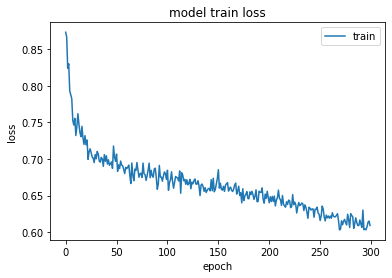

準確率 : 0.6517412935323383


In [49]:
# 無valid
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score


adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
optimizers = adam
kernel_init = 'glorot_uniform'
recurrent_init = 'glorot_uniform'
bias_init ='zero'
epochs = 300
batches = 80

model_LSTM = create_LSTM_model(optimizer=optimizers, batch_size=batches, kernel_init=kernel_init, 
                 recurrent_init=recurrent_init, bias_init=bias_init)

history = model_LSTM.fit(_X_train,_y_train,
           epochs=epochs,
           batch_size=batches)

#畫出LOSS圖
plt.plot(history.history['loss'])
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
#plt.savefig('plot.png')
plt.show()



preds = model_LSTM.predict(X_test_std)
actuals = y_test

#格式轉換
change_pred = []
for i in range(len(preds)):
    if(preds[i][0]>0.5):
        change_pred.append(1)
    else:
        change_pred.append(0)



accuracy = accuracy_score(actuals,change_pred)
print("準確率 : " + str(accuracy))

In [40]:
from sklearn import metrics
threshold = 0.5
preds = np.where(preds >= threshold, 1, 0)

t1r = list(map(int,preds[:,0]))
t1t = list(map(int,y_test[:,0]))

print('T+1 report\n %s'%(metrics.classification_report(t1r, t1t)))

T+1 report
               precision    recall  f1-score   support

           0       0.64      0.63      0.64       185
           1       0.69      0.70      0.69       217

    accuracy                           0.67       402
   macro avg       0.66      0.66      0.66       402
weighted avg       0.67      0.67      0.67       402



In [42]:
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 64)             34304     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 64)             256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 128)            98816     
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 128)            512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)              

In [44]:
# 將參數儲存至 HDF5 檔案
model_LSTM.save('KLSTM0(6716).h5')

In [39]:
from sklearn.metrics import accuracy_score

preds = loaded_model.predict(X_test_std)
actuals = y_test

#格式轉換
change_pred = []
for i in range(len(preds)):
    if(preds[i][0]>0.5):
        change_pred.append(1)
    else:
        change_pred.append(0)



accuracy = accuracy_score(actuals,change_pred)
print("準確率 : " + str(accuracy))

準確率 : 0.7562189054726368


## 其他的準確率判斷
from sklearn import metrics
print("準確率 : " + str(accuracy))
print('T+1 report\n %s'%(metrics.classification_report(actuals, change_pred)))

In [38]:
loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 5, 256)            333824    
_________________________________________________________________
batch_normalization_13 (Batc (None, 5, 256)            1024      
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 256)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 256)            525312    
_________________________________________________________________
batch_normalization_14 (Batc (None, 5, 256)            1024      
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 256)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 256)              

In [66]:
# 將參數儲存至 HDF5 檔案
model_LSTM.save('KLSTM(7114).h5')

In [35]:
from tensorflow import keras
# 從 HDF5 檔案中載入模型
loaded_model = keras.models.load_model('KLSTM1.h5',custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [36]:
score = loaded_model.evaluate(X_test_std, y_test, verbose=0)

In [37]:
score

[0.41312772035598755, 0.7562189102172852]

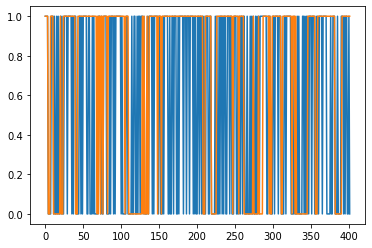

In [100]:
plt.plot(actuals)
plt.plot(change_pred)
plt.show()

# 同參數去跑個幾次，把好的結果記錄下來

Epoch 1/300
1606/1606 [==============================] - 2s 1ms/step - loss: 0.8147 - accuracy: 0.4994
Epoch 2/300
1606/1606 [==============================] - 1s 342us/step - loss: 0.7995 - accuracy: 0.5374
Epoch 3/300
1606/1606 [==============================] - 1s 345us/step - loss: 0.7992 - accuracy: 0.5224
Epoch 4/300
1606/1606 [==============================] - 1s 344us/step - loss: 0.7939 - accuracy: 0.5149
Epoch 5/300
1606/1606 [==============================] - 1s 342us/step - loss: 0.7758 - accuracy: 0.5349
Epoch 6/300
1606/1606 [==============================] - 1s 343us/step - loss: 0.7664 - accuracy: 0.5455
Epoch 7/300
1606/1606 [==============================] - 1s 343us/step - loss: 0.7486 - accuracy: 0.5411
Epoch 8/300
1606/1606 [==============================] - 1s 354us/step - loss: 0.7327 - accuracy: 0.5592
Epoch 9/300
1606/1606 [==============================] - 1s 351us/step - loss: 0.7261 - accuracy: 0.5679
Epoch 10/300
1606/1606 [==============================] -

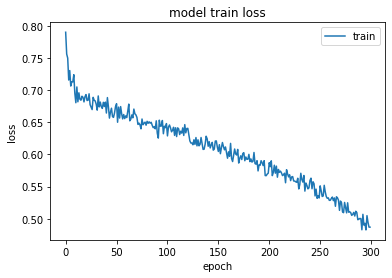

Epoch 1/300
1606/1606 [==============================] - 2s 1ms/step - loss: 0.8445 - accuracy: 0.4981
Epoch 2/300
1606/1606 [==============================] - 1s 344us/step - loss: 0.7830 - accuracy: 0.5405
Epoch 3/300
1606/1606 [==============================] - 1s 344us/step - loss: 0.7543 - accuracy: 0.5311
Epoch 4/300
1606/1606 [==============================] - 1s 343us/step - loss: 0.7292 - accuracy: 0.5585
Epoch 5/300
1606/1606 [==============================] - 1s 343us/step - loss: 0.7357 - accuracy: 0.5511
Epoch 6/300
1606/1606 [==============================] - 1s 342us/step - loss: 0.7168 - accuracy: 0.5629
Epoch 7/300
1606/1606 [==============================] - 1s 346us/step - loss: 0.7152 - accuracy: 0.5604
Epoch 8/300
1606/1606 [==============================] - 1s 343us/step - loss: 0.6999 - accuracy: 0.5778
Epoch 9/300
1606/1606 [==============================] - 1s 343us/step - loss: 0.7132 - accuracy: 0.5641
Epoch 10/300
1606/1606 [==============================] -

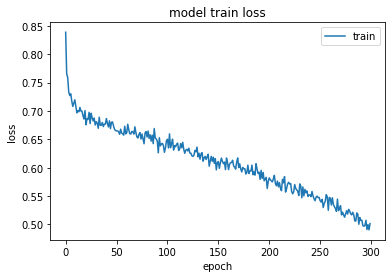

Epoch 1/300
1606/1606 [==============================] - 2s 1ms/step - loss: 0.8192 - accuracy: 0.5293
Epoch 2/300
1606/1606 [==============================] - 1s 345us/step - loss: 0.7645 - accuracy: 0.5697
Epoch 3/300
1606/1606 [==============================] - 1s 343us/step - loss: 0.7364 - accuracy: 0.5672
Epoch 4/300
1606/1606 [==============================] - 1s 343us/step - loss: 0.7270 - accuracy: 0.5741
Epoch 5/300
1606/1606 [==============================] - 1s 344us/step - loss: 0.7310 - accuracy: 0.5760
Epoch 6/300
1606/1606 [==============================] - 1s 344us/step - loss: 0.6886 - accuracy: 0.6083
Epoch 7/300
1606/1606 [==============================] - 1s 343us/step - loss: 0.6946 - accuracy: 0.5884
Epoch 8/300
1606/1606 [==============================] - 1s 345us/step - loss: 0.7016 - accuracy: 0.5859
Epoch 9/300
1606/1606 [==============================] - 1s 344us/step - loss: 0.7031 - accuracy: 0.5890
Epoch 10/300
1606/1606 [==============================] -

In [53]:
from keras.optimizers import Adam
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
optimizers = adam
kernel_init = 'glorot_uniform'
recurrent_init = 'glorot_uniform'
bias_init ='zero'
epochs = 300
batches = 80

r_count = 1
result = []

for i in range(10):
    
    model_LSTM = create_LSTM_model(optimizer=optimizers, batch_size=batches, kernel_init=kernel_init, 
                 recurrent_init=recurrent_init, bias_init=bias_init)

    history = model_LSTM.fit(_X_train,_y_train,
                             epochs=epochs,
                             batch_size=batches)


    preds = model_LSTM.predict(X_test_std)
    actuals = y_test

    #格式轉換
    change_pred = []
    for i in range(len(preds)):
        if(preds[i][0]>0.5):
            change_pred.append(1)
        else:
            change_pred.append(0)



    accuracy = accuracy_score(actuals,change_pred)
    print("準確率 : " + str(accuracy))

    #如果準確率>70，則將model及loss圖保存下來
    if (accuracy > 0.69):
        result.append(accuracy)
        model_LSTM.save('KLSTM'+str(r_count)+'.h5')
        

        plt.plot(history.history['loss'])
        plt.title('model train loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper right')
        plt.savefig('plot'+str(r_count)+'.png')   
        plt.show()
        
        r_count+=1





In [92]:
result

[0.7562189054726368,
 0.746268656716418,
 0.6691542288557214,
 0.681592039800995,
 0.6716417910447762]